In [61]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal Function Calling with Claude Models

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/partner-models/claude/claude_multimodal_function_calling.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fpartner-models%2Fclaude%2Fclaude_multimodal_function_calling.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/partner-models/claude/claude_multimodal_function_calling.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/partner-models/claude/claude_multimodal_function_calling.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

## Overview

### Claude on Vertex AI

Anthropic's Claude models on Vertex AI offer fully managed and serverless models as APIs. To use a Claude model on Vertex AI, send a request directly to the Vertex AI API endpoint.

In this notebook you'll use multimodal prompting and function calling (tools use) with Anthropic Claude models. To learn more about function calling with Claude, [check out the Anthropic docs.](https://docs.anthropic.com/en/docs/build-with-claude/tool-use)

### Available Anthropic Claude models

#### Claude 3.5 Sonnet v2
The upgraded Claude 3.5 Sonnet is now state-of-the-art for a variety of tasks including real-world software engineering, enhanced agentic capabilities, and computer use.

#### Claude 3.5 Sonnet
Anthropic's most powerful AI model. Claude 3.5 Sonnet outperforms competitor models and Claude 3 Opus at higher speeds and lower cost.

#### Claude 3 Opus
Claude 3 Opus is Anthropic's second-most intelligent AI model, with top-level performance on highly complex tasks.

#### Claude 3 Haiku
Anthropic Claude 3 Haiku is Anthropic's fastest, most compact vision and text model for near-instant responses to simple queries, meant for seamless AI experiences mimicking human interactions.

#### Claude 3 Sonnet
Anthropic Claude 3 Sonnet is engineered to be dependable for scaled AI deployments across a variety of use cases.

All Claude 3 models can process images and return text outputs, call tools, and feature a 200K context window

## Get started

Install the required packages

In [ ]:
%pip install --upgrade --user --quiet 'anthropic[vertex]' wikipedia

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
# Use the environment variable if the user doesn't provide Project ID.
import os

PROJECT_ID = "[your-project-id]"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-east5")

### Set up Anthropic client

#### Select Claude model

Models have different location availablity, so you'll need to select the model before you create the Anthropic client. You can see the [available regions for each model here.](https://cloud.google.com/vertex-ai/generative-ai/docs/partner-models/use-claude#regions)

In [41]:
MODEL = "claude-3-5-sonnet-v2@20241022"  # @param ["claude-3-5-sonnet-v2@20241022", "claude-3-5-sonnet@20240620", "claude-3-opus@20240229", "claude-3-haiku@20240307", "claude-3-sonnet@20240229" ]
if MODEL == "claude-3-5-sonnet-v2@20241022":
    available_regions = ["us-east5"]
elif MODEL == "claude-3-5-sonnet@20240620":
    available_regions = ["us-east5", "europe-west1", "asia-southeast1"]
elif MODEL == "claude-3-opus@20240229":
    available_regions = ["us-east5"]
elif MODEL == "claude-3-haiku@20240307":
    available_regions = ["us-east5", "europe-west1", "asia-southeast1"]
elif MODEL == "claude-3-sonnet@20240229":
    available_regions = ["us-east5"]

Next, choose from the available regions for the selected Claude model.

In [ ]:
from IPython.display import display
import ipywidgets as widgets

dropdown = widgets.Dropdown(
    options=available_regions,
    description="Select a location:",
    font_weight="bold",
    style={"description_width": "initial"},
)


def dropdown_eventhandler(change):
    global LOCATION
    if change["type"] == "change" and change["name"] == "value":
        LOCATION = change.new
        print("Selected:", change.new)


LOCATION = dropdown.value
dropdown.observe(dropdown_eventhandler, names="value")
display(dropdown)

#### Enable Claude model and accept terms of service

Before you can send messages to Claude, you'll need to enable the model on Vertex AI. You can do this from the model card in [Vertex AI Model Garden.](https://console.cloud.google.com/vertex-ai/model-garden) You will search for the Claude model you want to use and select the blue ENABLE button.

For example, here's the [link to enable Claude 3.2 Sonnet v2](https://console.cloud.google.com/vertex-ai/model-garden/questionnaire?model=publishers%2Fanthropic%2Fmodels%2Fclaude-3-5-sonnet-v2&mp=anthropic%2Fclaude-3-5-sonnet-v2.endpoints.mp-anthropic.cloud.goog). Note that if you do not enable the specific model you want to use and accept the terms of service, you will receive an error message when sending a prompt.

#### Create Anthropic client

Now you can import the AnthropicVertex SDK and initialize the client.

In [4]:
from anthropic import AnthropicVertex

client = AnthropicVertex(region=LOCATION, project_id=PROJECT_ID)

### Multimodal prompting

To start, create a multimodal prompt that contains an image.

If you want to send an image in your prompt, you'll need to base64 encode it first. You can follow the steps in the cell below to do so.

In [9]:
import base64

from IPython.display import Image
import httpx
import requests

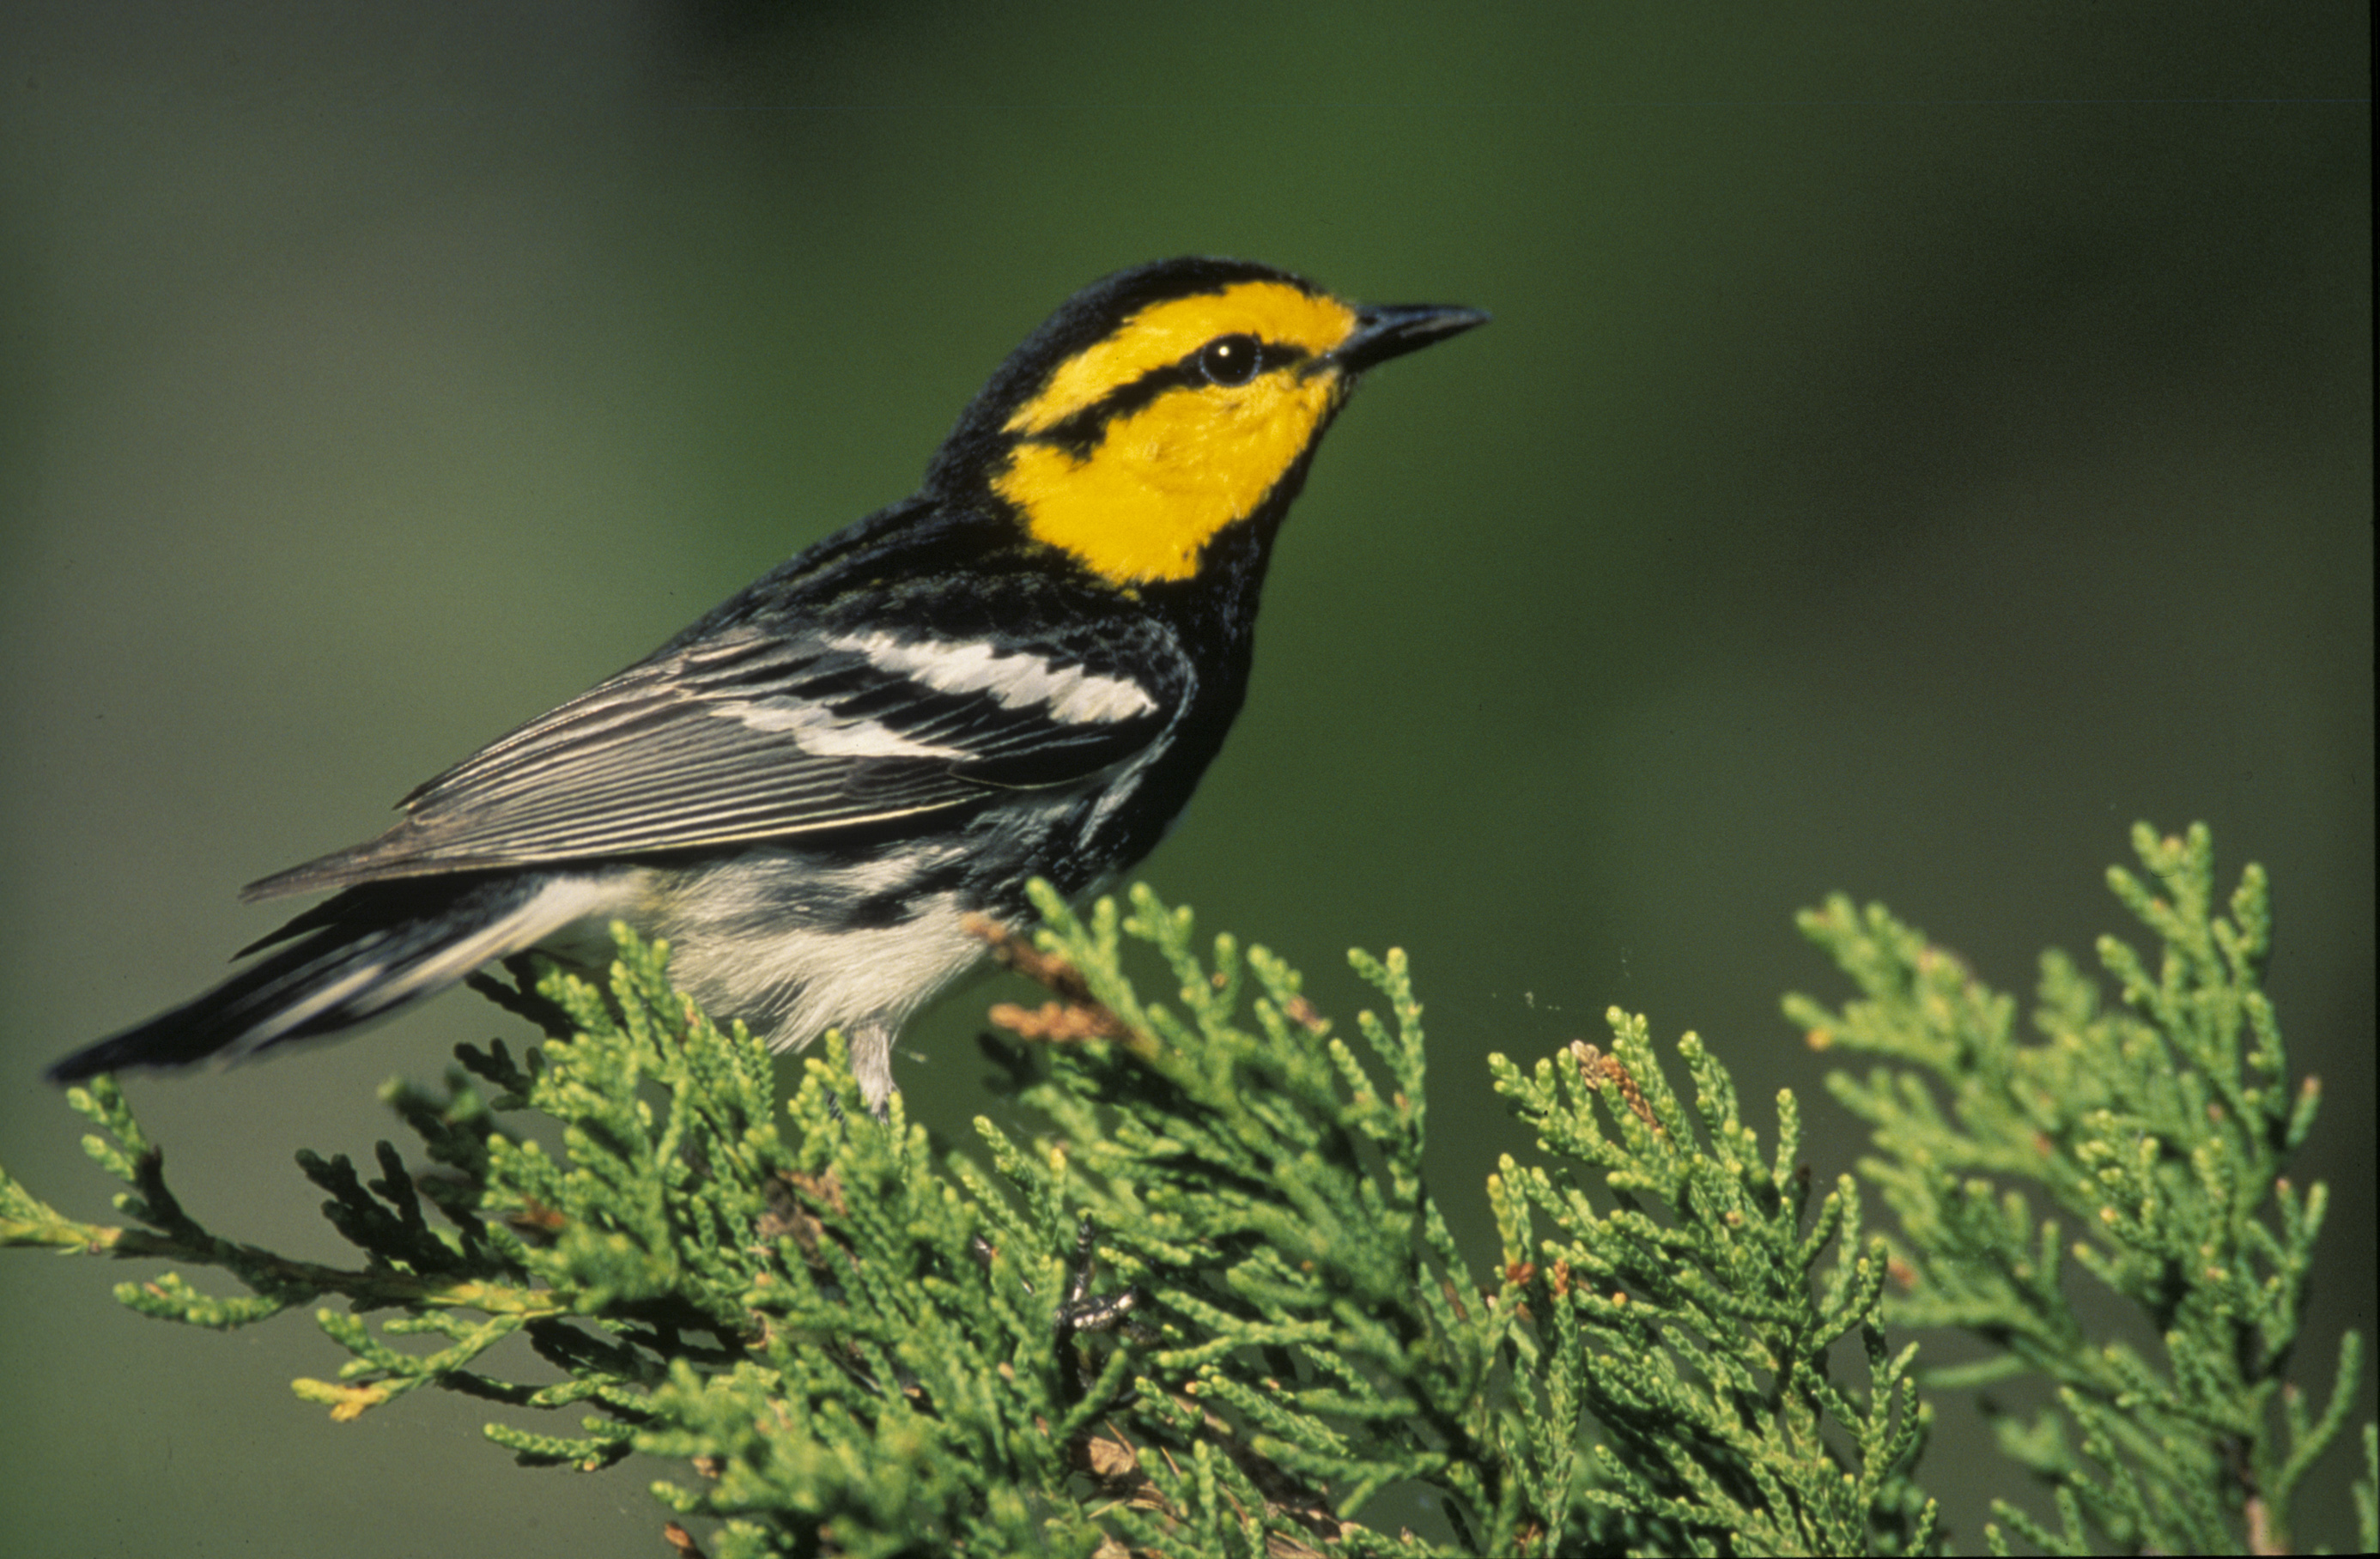

In [43]:
image_url = (
    "https://upload.wikimedia.org/wikipedia/commons/b/b7/Dendroica_chrysoparia1.jpg"
)
image_media_type = "image/jpeg"
image_b64 = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

headers = {
    "User-Agent": "Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Mobile Safari/537.36",
}

response = requests.get(image_url, headers=headers)
image = Image(response.content, width=300, height=200)

image

Next, define the user message to send to Claude. Because this is a multimodal message, it contains both `"type": "image"` and `"type": "text"`.

The image content contains the `"media_type"`, in this case `"image/jpeg"`, as well as the base64 encoded image.

In [19]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",  # pass in the image
                "source": {
                    "type": "base64",
                    "media_type": image_media_type,
                    "data": image_b64,
                },
            },
            {
                "type": "text",  # pass in the text
                "text": "What is the region where this animal lives?",
            },
        ],
    }
]

Once the message is defined, you can call `messages.create` to get a response from the model endpoint.

In [16]:
response = client.messages.create(
    max_tokens=1024,
    messages=messages,
    model=MODEL,
)

In [17]:
print(response.model_dump_json(indent=2))

{
  "id": "msg_vrtx_01PbLXjy7XzfNMiH76f3s5Ep",
  "content": [
    {
      "text": "This appears to be a Golden-cheeked Warbler (Setophaga chrysoparia), which has a very limited breeding range. It breeds exclusively in central Texas in the Edwards Plateau region, making it the only bird species whose breeding range is entirely within Texas. During winter, these warblers migrate to southern Mexico and Central America (primarily in southern Mexico, Guatemala, Honduras, and Nicaragua).\n\nThe bird is highly specialized in its habitat requirements, preferring mature juniper-oak woodlands, particularly areas with Ashe juniper (also known as cedar) trees, which is clearly visible in this image where the bird is perched on what appears to be juniper foliage. This specific habitat requirement is one reason why the species is considered endangered, as urban development and habitat fragmentation in central Texas have significantly reduced its breeding grounds.",
      "type": "text"
    }
  ],
  

### Multimodal function calling

What if you wanted Claude to retrieve specific information about the animal from a database instead of drawing on information from its training data?

Combining multimodal prompting with function calling can unlock some really neat use cases (If you're new to the concept of function calling or connecting LLMs to tools, check out this [introductory concepts video](https://www.youtube.com/watch?v=P3buv6P_u7c)).

As an example, let's say you want Claude to use a tool every time a user requests information about an animal's habitat. Instead of the answer coming from the model's training data, you want the model to pull the information from an external source of information accessible via an API. To do this, or use Claude with any other tools, there are four high level steps you'll follow.

* **STEP 1:** Define tool and send a request to Claude
* **STEP 2:** Claude decides to use a tool
* **STEP 3:** Developer makes an API call to the tool
* **STEP 4:** Claude uses tool result to formulate a conversational response


**STEP 1: Define tool and send a request to Claude**

The first thing you need to do is write a tool definition. This is a dictionary with information like a name and description of the tool, as well as the required input schema. Anthropic's [docs have some great tips](https://docs.anthropic.com/en/docs/build-with-claude/tool-use#best-practices-for-tool-definitions) for crafting successful tool descriptions.

Here, you define a tool called `get_wildlife_region`, with a simple description `Look up the region where an animal can be found.`

In [18]:
TOOL = {
    "name": "get_wildlife_region",
    "description": "Look up the region where an animal can be found",
    "input_schema": {
        "type": "object",
        "properties": {
            "animal": {"type": "string", "description": "species of animal"},
        },
    },
}

Next, send the same message as earlier, which contained the image of the warbler and the text _"What is the region where this animal lives?"_, but this time add in the tool parameter and pass in the `TOOL` dictionary defined above.

Note: for more information on sending messages to Claude, check out the [Messages API reference.](https://docs.anthropic.com/en/api/messages)

In [20]:
response = client.messages.create(
    max_tokens=1024,
    messages=messages,
    tools=[TOOL],  # pass in the tools!
    model=MODEL,
)

In [21]:
print(response.model_dump_json(indent=2))

{
  "id": "msg_vrtx_015F4GZi1En2FBwsTdrtrc12",
  "content": [
    {
      "text": "This appears to be a Golden-cheeked Warbler (Setophaga chrysoparia), a rare songbird. Let me look up its region for you.",
      "type": "text"
    },
    {
      "id": "toolu_vrtx_01AoZske3Zi12oYewSYnng2z",
      "input": {
        "animal": "Golden-cheeked Warbler"
      },
      "name": "get_wildlife_region",
      "type": "tool_use"
    }
  ],
  "model": "claude-3-5-sonnet-v2-20241022",
  "role": "assistant",
  "stop_reason": "tool_use",
  "stop_sequence": null,
  "type": "message",
  "usage": {
    "input_tokens": 1963,
    "output_tokens": 99
  }
}


**STEP 2: Claude decides to use a tool**

Even though the message sent to Claude was the same, the response will look different now because you provided Claude with a list of tool(s).

The content returned from the model contains a `TextBlock` and a `ToolUseBlock`.

In [24]:
response.content

[TextBlock(text='This appears to be a Golden-cheeked Warbler (Setophaga chrysoparia), a rare songbird. Let me look up its region for you.', type='text'),
 ToolUseBlock(id='toolu_vrtx_01AoZske3Zi12oYewSYnng2z', input={'animal': 'Golden-cheeked Warbler'}, name='get_wildlife_region', type='tool_use')]

In the `TextBlock`, there's an explanation from Claude indicating that the model has identified a tool is necessary. Depending on the model you use, you'll see something like _"Let me look up its region"_ or _"To answer your question about the typical habitat I'll need to use an available tool to look up its region"_, etc.


In [27]:
textblock = response.content[0]
print(textblock.model_dump_json(indent=2))

{
  "text": "This appears to be a Golden-cheeked Warbler (Setophaga chrysoparia), a rare songbird. Let me look up its region for you.",
  "type": "text"
}


In the `ToolUseBlock` there's a tool `id`, and then the API parameters specified in the tool definition, in this case the `"animal" : "Golden-cheeked Warbler"`.

At this point Claude has identified that calling the `get_wildlife_region` tool is necessary to respond to the user's query, but we as developers have to go do that ourselves. Claude can do a lot, but it isn't going to start actually making API calls on our behalf!

In [29]:
tooluseblock = response.content[1]
print(tooluseblock.model_dump_json(indent=2))

{
  "id": "toolu_vrtx_01AoZske3Zi12oYewSYnng2z",
  "input": {
    "animal": "Golden-cheeked Warbler"
  },
  "name": "get_wildlife_region",
  "type": "tool_use"
}


Note that in this example, you have only provided Claude with a single tool. However, you can define multiple tools when sending a message. Additionally, Claude supports [parallel tool use](https://docs.anthropic.com/en/docs/build-with-claude/tool-use#disabling-parallel-tool-use), meaning that the model may use multiple tools to answer a user query. For more details on configuring tools with Claude, [refer to the docs.](https://docs.anthropic.com/en/docs/build-with-claude/tool-use#controlling-claudes-output)

**STEP 3: Developer makes an API call to the tool**

Instead of creating an actual database of habitat information, you'll use the Wikipedia API to retrieve information about where the beloved warbler lives. 


In [30]:
import wikipedia

animal_name = response.content[1].input["animal"]  # Golden-cheeked Warbler
api_response = wikipedia.page(animal_name).content

The `api_response` is a huge blob of text from the Golden-cheeked Warbler Wikipedia page. The users of your wildlife chatbot would be pretty upset if you just dropped all of that text into the response box. So as a final step, you'll use Claude to format all of this information nicely and craft an eloquent response for the user

**STEP 4: Claude uses tool result to formulate a conversational response**

The messages list defined in Step 1 currently contains a single message from `"role" : "user"`.

Next, you'll add Claude's response from Step 2 to this list. To do this you'll append a new dictionary. This new dictionary has the `"role" : "assistant"` (instead of user). The value corresponding to the `content` key is the blob of text from Claude that contained the `TextBlock` and `ToolUseBlock`.


In [31]:
messages.append({"role": "assistant", "content": response.content})

Finally, you'll append one more dictionary to this messages list. This dictionary again will have the `"role" : "user"`, and the content will contain the tool id and api response (aka that big blob of Wikipedia text).


In [35]:
tool_use = response.content[-1]

# create tool response message
tool_response = {
    "role": "user",
    "content": [
        {"type": "tool_result", "tool_use_id": tool_use.id, "content": api_response}
    ],
}

In [36]:
# append tool_response dictionary to messages
messages.append(tool_response)

If you're tracking this closely, you'll notice that the messages list now contains three dictionaries.

In [37]:
len(messages)

3

These messages are:

1.   **[user]** Original user message, which included an image of the warbler and the text _"What is the region where this animal lives?"_
2.   **[assistant]** The response from the model, which included a `TextBlock`, as well as the `ToolUseBlock` that indicated what tool to call and the value `Golden-Cheeked Warbler` for the animal parameter
3. **[user]** Then the tool response you just formatted, which is a dictionary with the tool id from the model as well as the big blog of text returned from the API call made to Wikipedia.


Take all three of these dictionaries, and send all of them as messages to Claude.

In [38]:
follow_up_response = client.messages.create(
    model=MODEL,
    messages=messages,  # long list with three dictionaries
    max_tokens=1000,
    tools=[TOOL],  # don't forget the tool!
)

After all the hard work, Claude will responds with something fluent and conversational, based on info extracted from the tool.

In [39]:
follow_up_response.content[0].text

"Based on the results, the Golden-cheeked Warbler is endemic to (meaning it exclusively breeds in) Central Texas, specifically in an area from Palo Pinto County southwestward along the eastern and southern edge of the Edwards Plateau to Kinney County. It's the only bird species with a breeding range that is completely endemic to Texas.\n\nDuring the breeding season (March to June), these warblers can be found in various Texas state parks including Colorado Bend, Dinosaur Valley, Garner, Guadalupe River, and several others. However, during winter months (November-February), they migrate to parts of Mexico and Central America, specifically Guatemala, Nicaragua, and Honduras.\n\nThe bird requires a very specific habitat of juniper-oak woodlands, particularly areas with mature Ashe juniper trees, which they use for nesting material. Their total breeding range is quite limited, covering only about 1,768 square kilometers (437,000 acres), which is one reason why this species is currently end

🥳 Congratulations! You've successfully used Claude with tools